In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from time import time
%matplotlib inline

In [38]:
def compareFloats(num1, num2, eps = 0.00001, onlyEquality=True):
    '''
        # Método que compara 2 floats até certa precisão
        # Exemplo:
        # a = 1.55555; b = 1.55566; eps = 0.0001
        # Para o eps acima, a < b, enquanto, para eps = 0.001, a == b
    '''
    subtr = num1-num2
    if subtr < eps:
        return False
    elif onlyEquality:
        return True
    else:
        return 1 if subtr > 0 else -1

In [39]:
def fixTimestamp(ts:str):
    new_ts = ts[:10]+'.'+ts[10:]
    return float(new_ts)

In [40]:
def getData(date_str:str):
    date = dt.strptime(date_str, '%Y-%m-%d')
    return date

In [4]:
dataset = pd.read_csv('testdata.csv')

In [5]:
dataset.head()

,user,latitude,longitude,date,day_of_week,hour,categoria,timestamp
0,User_3401,-26.489503,-49.028018,2018-07-08,Saturday,18,bakery,1531604419436
1,User_539,-14.457400,-46.433148,2018-07-08,Sunday,7,restaurant,1531650749377
2,User_789,-8.903859,-36.487485,2018-07-08,Saturday,9,night_club,1531571345816
3,User_2814,-22.823960,-43.012243,2018-07-08,Saturday,22,store,1531619273330
4,User_3432,-24.949576,-53.488507,2018-07-08,Sunday,3,restaurant,1531634482205


<h1>Análise dos Dados</h1>
<p>Inicialmente podemos analisar o dataset buscando valores únicos que podem retornar algum insight.</p>

<h2>Limpando o Dataset</h2>
<p>Através de algumas análises de colunas, notei que alguns valores são irelevantes:</p>
<ul>
    <li>Posso substituir a coluna de data por uma só contendo os dias do mês. Todas as datas são do mês 7</li>
    <li>Timestamp é irelevante dado que a tabela já contém dia, mês, ano, dia da semana e hora. A única relevancia seria especificar ainda mais além do que já é dado. Além disso o timestamp não está bem formatado e, tentando corrigir, as datas não batem com o que é dado nas outras colunas</li>
</ul>

In [6]:
curr_timestamp = time()
first_timestamp_ds = dataset['timestamp'][0]
print('Comparando Timestamps:')
print('%f\n%.d'%(curr_timestamp, first_timestamp_ds))

Comparando Timestamps:
1532041223.475892
1531604419436


<p>Comparando o tamanho dos dois notei que o timestamp do dataset não possui decimal, porém é 4 dígitos maior do que um timestamp correto. Deduzi que esses dígitos a mais seria decimal. Então consertei e comparei a data com o novo timestamp e a data presente no dataset:</p>

In [7]:
# for _, row in dataset[['hour','date','timestamp']].iterrows():
#     datetime_ts = dt.utcfromtimestamp(row['timestamp']/1000)
#     print(datetime_ts.date(), datetime_ts.hour, end = '\t')
#     print(row['date'], row['hour'])

<p>Houve uma inconsistência no dia ou na hora.</p>

In [8]:
dataset = dataset.drop(columns=['timestamp'])

<p>Comparando o dataset completo com aquele filtrando pelo mês 7 de 2018:</p>

In [9]:
dataset[dataset['date'].str.contains(r'2018-07-*.')].shape== dataset.shape

True

In [10]:
dataset['date'] = dataset['date'].apply(lambda date_str: date_str[-2:])
dataset.rename(columns={'date': 'dia'}, inplace=True)

<h2>Novo Dataset</h2>
<p>Dataset após todas as mudanças anteriores</p>

In [11]:
dataset.head()

,user,latitude,longitude,dia,day_of_week,hour,categoria
0,User_3401,-26.489503,-49.028018,08,Saturday,18,bakery
1,User_539,-14.457400,-46.433148,08,Sunday,7,restaurant
2,User_789,-8.903859,-36.487485,08,Saturday,9,night_club
3,User_2814,-22.823960,-43.012243,08,Saturday,22,store
4,User_3432,-24.949576,-53.488507,08,Sunday,3,restaurant


<h2>Analisando Atributos Isoladamente</h2>
<p>Em uma primeira passada pela base de dados podemos extrair várias informações com base nas colunas. O objetivo dessa sessão é tentar visualizar o máximo de informação de cada coluna.</p>

<h3>Day of Week</h3>
<p>Analisando os dias da semana é possível discutir qual o melhor dia da semana para se vincular uma campanha.</p>

In [16]:
dataset['day_of_week'].value_counts()

Thursday     4735
Friday       4542
Wednesday    4500
Tuesday      4477
Sunday       4415
Saturday     4187
Monday       3946
Name: day_of_week, dtype: int64

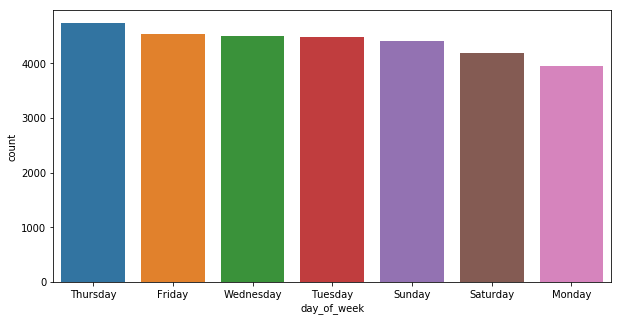

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataset, 
              x='day_of_week', 
              order=dataset['day_of_week'].value_counts().index)
plt.show()

<p>Notamos claramente que o dia com maior movimentação de clientes é Quinta-feira e o dia com menor movimentação é Segunda-Feira, porém os valores entre [Sexta-feira, Terça-feira] acima não variam muito entre si e mantém um valor acima aos 3 últimos. É possível imaginar que os melhores dias para se vincular uma campanha seja Terça, Quarta, Quinta e Sexta.</p>

<h3>Hour</h3>
<p>A partir da coluna de horas é possível saber qual o melhor horário para vincular uma campanha com base no número de usuários presentes em estabelecimentos, assim como os piores horários.</p>

In [14]:
hour_count = dataset['hour'].value_counts()
hour_count[:5]

12    2474
13    2397
14    1966
18    1884
17    1880
Name: hour, dtype: int64

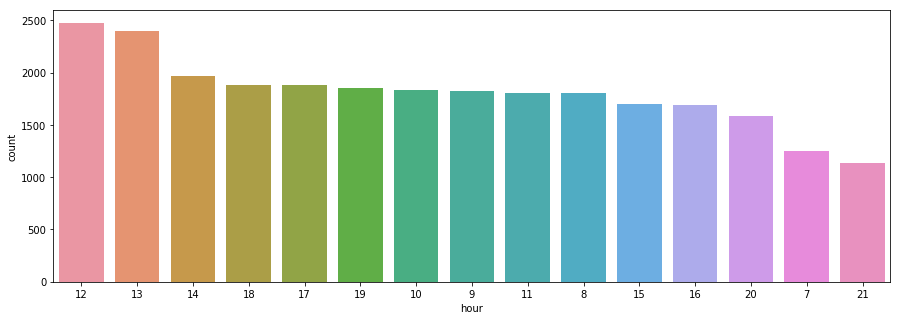

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(data = dataset, x = 'hour', order=dataset['hour'].value_counts()[:15].index)
plt.show()

In [19]:
# Quais são as horas cuja sua contagem é superior a mediana das contagens
hour_count[hour_count > hour_count.median()].keys().sort_values()

Int64Index([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

<p>A partir do array acima temos uma faixa de horário ideal para rodar um anúncio de promoção.</p>

<h3>Categoria</h3>
<p>A partir da categoria dos estabelecimentos podemos prever qual a categoria mais visitada por clientes, daí vincular propagandas mais direcionadas a esse público.</p>

In [22]:
dataset['categoria'].value_counts()[:5]

restaurant                5826
store                     3461
school                    1728
doctor                    1203
grocery_or_supermarket    1103
Name: categoria, dtype: int64

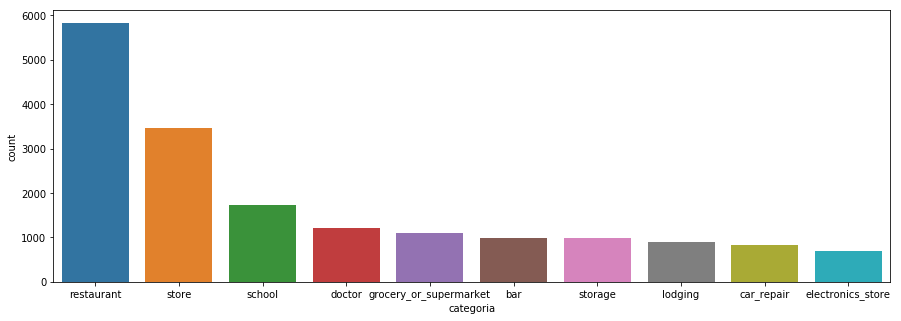

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(data=dataset, x = 'categoria', order=dataset['categoria'].value_counts()[:10].index)
plt.show()